In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls  "/content/gdrive/My Drive/NMT_english2marthi"

attention.py	   NMT_Etokenizer.pkl	__pycache__
dev_test.tgz	   NMT_marathi.ipynb	README.md
en-hi.csv	   NMT_model.json	tokenizer_input.pkl
language_data.csv  NMT_model_weight.h5	tokenizer_target.pkl
mar.txt		   NMT_Mtokenizer.pkl	train_model.png
NMT_data.pkl	   parallel.tgz


In [ ]:
cd "/content/gdrive/My Drive/NMT_english2marthi"

/content/gdrive/My Drive/NMT_english2marthi


#Import Libraries
Importing libraries as well as Attention layer mechanism by keeping attention.py in the same folder

In [ ]:
from attention import AttentionLayer

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

#Dataframe 
 passing the data into dataframe object 

In [ ]:
language_data = pd.read_csv('en-hi.csv')


In [ ]:
language_data.head()


,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
language_data['source'].value_counts()

tides        49857
ted          38803
indic2012    36167
Name: source, dtype: int64

In [ ]:
pd.isnull(language_data).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

Using Source as TED so as to get low number on the length of the words in both English and Hindi

In [ ]:
language_data=language_data[language_data['source']=='ted']

In [ ]:
language_data=language_data.sample(n=30000,random_state=42) # sampling data from 38k values
language_data.shape

(30000, 3)

In [ ]:
english_text = language_data['english_sentence'].values
hindi_text = language_data['hindi_sentence'].values

In [ ]:
english_text[0], hindi_text[0]


("We still don't know who her parents are, who she is.",
 'हम अभी तक नहीं जानते हैं कि उसके माता-पिता कौन हैं, वह कौन है,')

In [ ]:
len(english_text), len(hindi_text)


(30000, 30000)

# Pre-processing Functions



1.   Clean the data by lowercasing, removing punctuations, any numbers both in english and Hindi languages.

2.  Adding Start and End sequence to the Hindi text



In [ ]:
english_text_ = [x.lower() for x in english_text]
hindi_text_ = [x.lower() for x in hindi_text]

In [ ]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
hindi_text_ = [re.sub("'",'',x) for x in hindi_text_]

In [ ]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
hindi_text_ = remove_punc(hindi_text_)

In [ ]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
hindi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in hindi_text_]
hindi_text_ = [re.sub("[\u200d]","",x) for x in hindi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
hindi_text_ = [x.strip() for x in hindi_text_]

In [ ]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
hindi_text_ = [x.strip() for x in hindi_text_]

In [ ]:
# Putting the start and end words in the Hindi sentances
hindi_text_ = ["start " + x + " end" for x in hindi_text_]

In [ ]:
# manipulated_marathi_text_
hindi_text_[0], english_text_[0]

('start हम अभी तक नहीं जानते हैं कि उसके मातापिता कौन हैं वह कौन है end',
 'we still dont know who her parents are who she is')

In [ ]:
X = english_text_
Y = hindi_text_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(27000, 27000, 3000, 3000)

In [ ]:
X_train[0], y_train[0]

('we are obsessed with trying to figure it out',
 'start हम उसे समझने की कोशिश कर रहे हैं end')

# Max length for Text sequences

In [ ]:

def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_hindi = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_hindi_test = Max_length(y_test)

In [ ]:
max_length_hindi, max_length_english


(33, 21)

# Vocabulary for English and Hindi sentences 

> English sentences turned to sequences using tokenizer and padding post with max length of the english text sequences

> Similarly goes with the Hindi Tokenizer




In [ ]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')


In [ ]:
hindiTokenizer = Tokenizer()
hindiTokenizer.fit_on_texts(y_train)
Hword2index = hindiTokenizer.word_index
vocab_size_target = len(Hword2index) + 1

y_train = hindiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')

y_test = hindiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_marathi, padding='post')

In [ ]:
vocab_size_source, vocab_size_target

(14531, 18502)

In [ ]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)


Batch Generator to go alaong with large sets of data.

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_english),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_marathi),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_marathi, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = englishTokenizer.word_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = marathiTokenizer.word_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, marathiTokenizer.word_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Making LSTM model

> model with 3 Lstm layers to orm encoder - decoder sequence model

> Adding Attention Layer using backend as keras


> Follow te blog: 

*   https://github.com/thushv89/attention_keras

*   https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39









In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_length_english,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 500)      7265500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 21, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

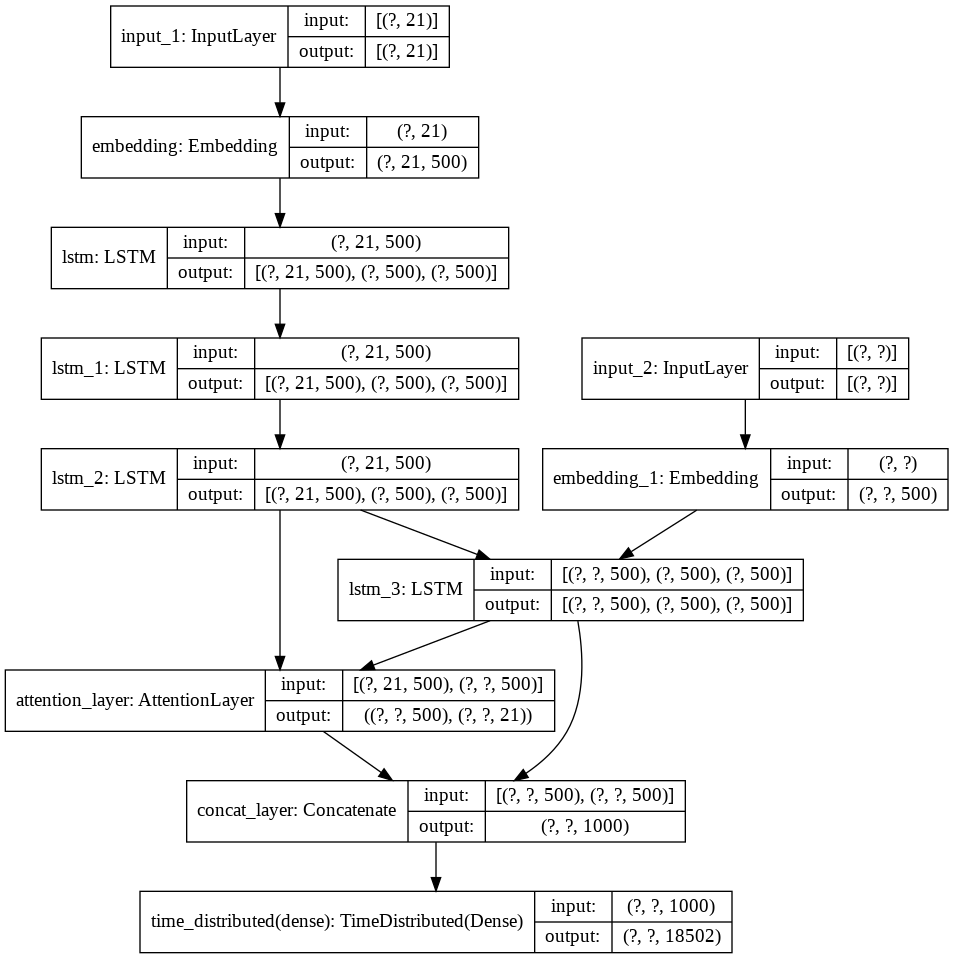

In [ ]:
plot_model(model, to_file='train_model.png', show_shapes=True)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the Model

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=25,
                    batch_size=64,validation_batch_size=16,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/25
422/422 [==============================] - 165s 390ms/step - loss: 1.9751 - accuracy: 0.7394 - val_loss: 1.5923 - val_accuracy: 0.7652
Epoch 2/25
422/422 [==============================] - 164s 388ms/step - loss: 1.6490 - accuracy: 0.7596 - val_loss: 1.5090 - val_accuracy: 0.7728
Epoch 3/25
422/422 [==============================] - 164s 388ms/step - loss: 1.5274 - accuracy: 0.7686 - val_loss: 1.4498 - val_accuracy: 0.7803
Epoch 4/25
422/422 [==============================] - 164s 389ms/step - loss: 1.3994 - accuracy: 0.7792 - val_loss: 1.4103 - val_accuracy: 0.7866
Epoch 5/25
422/422 [==============================] - 164s 390ms/step - loss: 1.2606 - accuracy: 0.7891 - val_loss: 1.3822 - val_accuracy: 0.7910
Epoch 6/25
422/422 [==============================] - 164s 390ms/step - loss: 1.1036 - accuracy: 0.8005 - val_loss: 1.3762 - val_accuracy: 0.7927
Epoch 7/25
422/422 [==============================] - 164s 389ms/step - loss: 0.9353 - accuracy: 0.8188 - val_loss: 1.3852 -

In [ ]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

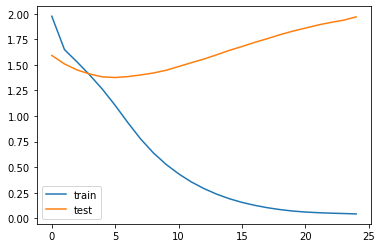

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

The Model Overfits heavily with training loss decreasing to almost 0.03 whereas the validatoin test set struggles to decrease loss by 1.3

In [ ]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Hword2index, hindiTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [ ]:
Eindex2word = englishTokenizer.index_word
Hindex2word = hindiTokenizer.index_word

In [ ]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 500)      7265500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 21, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Inference Model

must be very similar to decoder model keeping almost everything intact

In [ ]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 21, 500)
(None, None)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Hindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Hword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

Results for train data

In [ ]:
for i in range(10):
  
  print("Review:",seq2text(X_train[i]))
  print("Original summary:",seq2summary(y_train[i]))
  print("Predicted summary:",decode_sequence(X_train[i].reshape(1,21)))
  print("\n")

Review: for with shoulder not im and knowledge this them 
Original summary: यह मे नदी का शब्द जो आप और 
Predicted summary:  यह मे नदी का शब्द जो आप और


Review: call the cricket lrb well andaman lrb large 
Original summary: शिखर जिन्होंने लिखा की दूसरे थी तब अगर की सके 
Predicted summary:  शिखर जिन्होंने लिखा की दूसरे की तब अगर की सके


Review: a for have each in now and without 
Original summary: अलावा की भीतर पर 
Predicted summary:  हैं यह की से को किमी उनसे होगा वह के


Review: of and thirst people who small people 
Original summary: में करना पुरुष भारत पर में करना कर अध्ययन ईश्वर पर हैं 
Predicted summary:  में करना पुरुष भारत पर में करना कर अध्ययन ईश्वर पर हैं


Review: it main brought may stone your it mamata after money 
Original summary: लिए टन एक सदस्य भी फिल्म वह कहा जाए जन्म शहर मानवीय का के 
Predicted summary:  लिए टन एक सदस्य भी फिल्म वह कहा जाए जन्म शहर मानवीय का के


Review: of that only that literary water problem 
Original summary: में दिन अंत करना बनना भारतीय किया प्र